In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

import math
import matplotlib.pyplot as plt

In [2]:
merged_df = pd.read_csv('data/r_results.csv')
n_seq = 63

merged_df['Exchange.Date'] = merged_df['Exchange.Date'].apply(lambda x: date(1900, 1, 1) + timedelta(int(x)))
merged_df.index = merged_df['Exchange.Date']

merged_df.head()

,Exchange.Date,Close,logreturns,forecast,lower,upper
Exchange.Date,,,,,,
2003-01-01,2003-01-01,100.000000,0.000000,100.000000,100.000000,100.000000
2003-01-04,2003-01-04,100.995362,0.009904,100.995362,100.995362,100.995362
2003-01-05,2003-01-05,101.623083,0.006196,101.623083,101.623083,101.623083
2003-01-08,2003-01-08,101.623083,0.000000,101.623083,101.623083,101.623083
2003-01-09,2003-01-09,102.392342,0.007541,102.392342,102.392342,102.392342


In [3]:
merged_df['error'] = merged_df['forecast'] - merged_df['Close']
merged_df['abs_error'] = np.abs(merged_df['forecast'] - merged_df['Close'])

merged_df['actual_up'] = merged_df['Close'].diff(1) > 0
merged_df['forecast_up'] = merged_df['forecast'].diff(1) > 0

def confusion(actual, forecast):
    if (actual and forecast):
        return 'TP'
    
    if (actual and not forecast):
        return 'FN'
    
    if (not actual and forecast):
        return 'FP'
    
    if (not actual and not forecast):
        return 'TN'
    
    return False

merged_df['confusion'] = merged_df.apply(lambda x: confusion(x['actual_up'], x['forecast_up']), axis=1)

merged_df.tail()

,Exchange.Date,Close,logreturns,forecast,lower,upper,error,abs_error,actual_up,forecast_up,confusion
Exchange.Date,,,,,,,,,,,
2016-10-22,2016-10-22,671.89,0.005567,657.637739,255.792032,1690.777438,-14.252261,14.252261,True,True,TP
2016-10-23,2016-10-23,671.08,-0.001206,658.205370,251.688108,1721.314181,-12.874630,12.874630,False,True,FP
2016-10-26,2016-10-26,668.82,-0.003373,658.773490,247.648335,1752.414414,-10.046510,10.046510,False,True,FP
2016-10-27,2016-10-27,668.02,-0.001197,659.342101,243.671832,1784.088057,-8.677899,8.677899,False,True,FP
2016-10-28,2016-10-28,663.33,-0.007046,659.911202,239.757723,1816.345223,-3.418798,3.418798,False,True,FP


# Evaluating at t = 1

In [4]:
# New dataframe that only contains the number of periods to evaluate (1,3,5,21,63)
def new_df(n_periods):
    start = -n_seq
    end = -n_seq + n_periods if n_periods != 63 else None
    df = merged_df[start : end]
    return df

In [5]:
# Calculating RMSE and MAE
def evaluate(n_periods):
    df = new_df(n_periods)
    mape = ((df['abs_error'] / df['Close']).sum() / n_periods) * 100
    rmse = math.sqrt(pow(df['error'].sum(), 2) / n_periods)
    print(f"{n_periods}, RMSE: {round(rmse, 3)}, MAPE: {round(mape, 3)}%")

evaluate(1) # 1 day
evaluate(3) # half a week
evaluate(5) # week
evaluate(21) # month
evaluate(63) # quarter

1, RMSE: 0.025, MAPE: 0.004%
3, RMSE: 7.525, MAPE: 0.706%
5, RMSE: 9.852, MAPE: 0.713%
21, RMSE: 2.324, MAPE: 0.541%
63, RMSE: 43.548, MAPE: 1.063%


In [6]:
# Creating confusion matrix
def confusion_matrix(df):
    conf = pd.DataFrame(columns=['P', 'N'], index=['P', 'N'])
    conf.loc['P', 'P'] = len(df[df['confusion'] == 'TP'])
    conf.loc['P', 'N'] = len(df[df['confusion'] == 'FN'])
    conf.loc['N', 'P'] = len(df[df['confusion'] == 'FP'])
    conf.loc['N', 'N'] = len(df[df['confusion'] == 'TN'])
    return conf

confusion = confusion_matrix(new_df(21))
precision = confusion.iloc[0, 0] / (confusion.iloc[0,0] + confusion.iloc[0,1])
recall = confusion.iloc[0, 0] / (confusion.iloc[0,0] + confusion.iloc[1,0])
f_score = 2*precision*recall/(precision+recall)

print(confusion)
print(f'precision: {int(precision*100)}%, recall: {int(recall*100)}%, f-score: {round(f_score, 3)}')

    P  N
P  13  0
N   8  0
precision: 100%, recall: 61%, f-score: 0.765


# Plotting

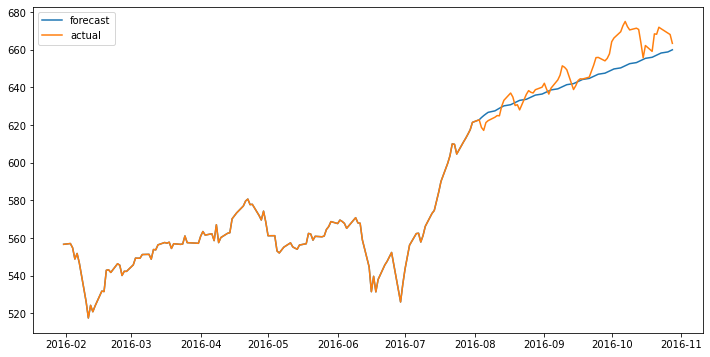

In [7]:
# Without confidence intercal
plot_df = merged_df[-n_seq - n_seq*2 :]
plt.figure(figsize=(12, 6))
plt.plot(plot_df['forecast'], label="forecast")
plt.plot(plot_df['Close'], label="actual")
plt.legend()

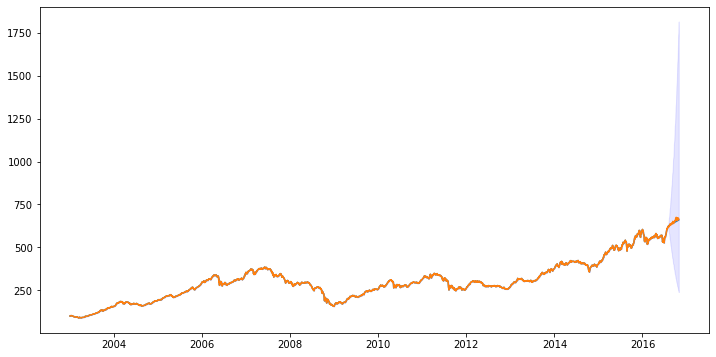

In [8]:
# With confidence interval
# HÖGST OSÄKER PÅ OM CI ÄR BERÄKNAD KORREKT I R

plot_df = merged_df

x = plot_df.index
y = plot_df['forecast']

plt.figure(figsize=(12, 6))
plt.plot(x,y)
plt.fill_between(x, plot_df['lower'], plot_df['upper'], color='blue', alpha=0.1)
plt.plot(plot_df['Close'], label="actual")

# Cross-validation

In [23]:
r_cross_df = pd.read_csv('data/r_cross_val.csv')

r_cross_df['error'] = r_cross_df['forecast'] - r_cross_df['Close']
r_cross_df['abs_error'] = np.abs(r_cross_df['forecast'] - r_cross_df['Close'])

r_cross_df

,time,Close,forecast,lower,upper,error,abs_error
0,1,622.77,622.745083,614.850489,630.741043,-0.024917,0.024917
1,1,618.70,623.922645,607.986288,640.276720,5.222645,5.222645
2,1,617.12,624.955354,600.876362,649.999267,7.835354,7.835354
3,1,621.28,625.876251,593.586507,659.922484,4.596251,4.596251
4,1,622.31,626.710896,586.166551,670.059638,4.400896,4.400896
...,...,...,...,...,...,...,...
63310,1000,1126.33,1058.925124,387.348941,2894.863779,-67.404876,67.404876
63311,1000,1132.38,1059.901386,381.098201,2947.772893,-72.478614,72.478614
63312,1000,1116.59,1060.878547,374.947985,3001.651793,-55.711453,55.711453
63313,1000,1114.67,1061.856609,368.896701,3056.518141,-52.813391,52.813391


In [27]:
def cross_evaluate(df, n_periods):
    df = df[-63:-63+n_periods] if n_periods < 63 else df.tail(63)
    mape = ((df["abs_error"] / df["Close"]).sum() / n_periods) * 100
    rmse = math.sqrt(pow(df["error"].sum(), 2) / n_periods)
    return mape, rmse

cross_df = pd.DataFrame(columns=[
    "mape_1", 
    "mape_3",
    "mape_5",
    "mape_21",
    "mape_63",
    "rmse_1",
    "rmse_3",
    "rmse_5",
    "rmse_21",
    "rmse_63"
])

len_forecasts = 1000

for i in range(len_forecasts):
    cross_merged_df = r_cross_df[i:i+63]
    one = cross_evaluate(cross_merged_df, 1)
    three = cross_evaluate(cross_merged_df, 3)
    five = cross_evaluate(cross_merged_df, 5)
    twentyone = cross_evaluate(cross_merged_df, 21)
    sixtythree = cross_evaluate(cross_merged_df, 63)

    cross_df = cross_df.append({
        'mape_1': one[0],
        'mape_3': three[0],
        'mape_5': five[0],
        'mape_21': twentyone[0],
        'mape_63': sixtythree[0],
        'rmse_1': one[1],
        'rmse_3': three[1],
        'rmse_5': five[1],
        'rmse_21': twentyone[1],
        'rmse_63': sixtythree[1],
    }, ignore_index=True)

cross_df.head(1)

,mape_1,mape_3,mape_5,mape_21,mape_63,rmse_1,rmse_3,rmse_5,rmse_21,rmse_63
0,0.004001,0.705933,0.712958,0.541432,1.063077,0.024917,7.524653,9.852218,2.323509,43.548246


In [28]:
cross_df.describe()

,mape_1,mape_3,mape_5,mape_21,mape_63,rmse_1,rmse_3,rmse_5,rmse_21,rmse_63
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.567065,1.567610,1.568478,1.574839,1.577985,10.306489,17.489946,22.238871,44.151222,74.172557
std,1.115984,1.056197,1.005184,0.778286,0.503429,7.498028,12.687017,15.961572,27.154203,35.261236
min,0.001473,0.071653,0.110460,0.414442,0.832667,0.009604,0.024192,0.030955,0.037087,0.199110
25%,0.639608,0.672280,0.754531,0.962824,1.082969,4.029878,7.145399,9.323661,23.372182,44.715658
50%,1.362646,1.323245,1.318126,1.404297,1.496611,8.945984,14.937902,19.223708,40.261691,73.879992
75%,2.262575,2.215136,2.151697,2.086046,1.897973,14.889321,25.217643,31.608734,63.111233,98.527169
max,5.206885,4.973778,4.785432,3.707443,2.630337,35.143873,58.007044,71.915080,113.468023,136.886965


In [30]:
n = cross_df.count()[0]
mean = cross_df.mean()
upper = cross_df.mean() + 1.96 * cross_df.std() / math.sqrt(n)
lower = cross_df.mean() - 1.96 * cross_df.std() / math.sqrt(n)

ci_df = pd.DataFrame(columns=['measure', 'mean', 'lower', 'upper'])

for i in range(10):
    ci_df = ci_df.append({
        'measure': cross_df.columns[i],
        'mean': mean[i],
        'lower': lower[i],
        'upper': upper[i]
    }, ignore_index=True)

ci_df

,measure,mean,lower,upper
0,mape_1,1.567065,1.497895,1.636234
1,mape_3,1.567610,1.502146,1.633073
2,mape_5,1.568478,1.506176,1.630780
3,mape_21,1.574839,1.526600,1.623077
4,mape_63,1.577985,1.546782,1.609188
5,rmse_1,10.306489,9.841756,10.771221
6,rmse_3,17.489946,16.703597,18.276296
7,rmse_5,22.238871,21.249562,23.228179
8,rmse_21,44.151222,42.468187,45.834257
9,rmse_63,74.172557,71.987043,76.358071
